
<h1>🏁 F1 Strategy Outcome Dataset </h1>

<hr style="border:1px solid #ddd;">


<div style="background-color:#fff9c4; padding:16px; border-radius:1px; border-left:1px solid #fbc02d;">

<h3>🏎️ Decision Tree Analysis for F1 PodiumFinish Prediction</h3>

<h4> Purpose of this analysis</h4>
In this notebook, a Decision Tree classifier is used to analyze how various race-day factors influence whether a Formula 1 driver finishes on the podium. The dataset includes categorical features such as starting position, weather conditions, pit strategy, and safety car presence, which together represent realistic elements that affect race outcomes.

The resulting decision tree demonstrates how:
- Starting position serves as a primary split due to its strong influence on race outcomes.
- Weather conditions and safety car presence act as secondary decision factors that refine predictions when grid position alone is insufficient.
- Additional features, such as pit strategy, are used in deeper levels to handle residual uncertainty.

By visualizing and interpreting this tree, the notebook highlights how decision trees translate domain knowledge into a sequence of logical rules, while also illustrating the impact of data structure and noise on model complexity and interpretability.

🎯 Target --> **PodiumFinish → Yes / No**
</div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3>  📂
    Dataset Overview </h3>
</div>

🧠 Key Features

| Feature             | Categories         |
| ------------------- | ------------------ |
| `Weather`           | Dry / Wet          |
| `Starting_Position` | Front / Mid / Back |
| `Pit_Strategy`      | OneStop / TwoStop  |
| `Safety_Car`        | Yes / No           |
| `PodiumFinish`      | Yes / No           |


**Importing the Required Files**

In [56]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [57]:
data = {
    'Weather': [
        'Dry','Wet','Dry','Wet','Dry','Wet','Dry','Wet','Dry','Wet',
        'Dry','Wet','Dry','Wet'
    ],
    'Starting_Position': [
        'Front','Front','Mid','Mid','Back','Back','Front','Mid','Back','Front',
        'Mid','Back','Front','Back'
    ],
    'Pit_Strategy': [
        'TwoStop','OneStop','TwoStop','OneStop','TwoStop','OneStop','OneStop','TwoStop','OneStop','TwoStop',
        'TwoStop','OneStop','TwoStop','OneStop'
    ],
    'Safety_Car': [
        'Yes','No','Yes','No','Yes','No','No','Yes','No','Yes',
        'Yes','No','Yes','No'
    ],
    'PodiumFinish': [
        'No','Yes','Yes','No','Yes','No','No','Yes','Yes','No',
        'No','Yes','Yes','No'
    ]
}
df = pd.DataFrame(data)
df.head(5)


,Weather,Starting_Position,Pit_Strategy,Safety_Car,PodiumFinish
0,Dry,Front,TwoStop,Yes,No
1,Wet,Front,OneStop,No,Yes
2,Dry,Mid,TwoStop,Yes,Yes
3,Wet,Mid,OneStop,No,No
4,Dry,Back,TwoStop,Yes,Yes


<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3>   Finding Entropy</h3>
</div>

In [58]:
def calculate_entropy(target_column):
    values, counts = np.unique(target_column, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy
entropy_root = calculate_entropy(df['PodiumFinish'])
print("Entropy at root node:", round(entropy_root, 4))

Entropy at root node: 1.0


In [59]:
def entropy_after_split(df, feature, target):
    total = len(df)
    weighted_entropy = 0.0
    for value, subset in df.groupby(feature):
        weight = len(subset) / total
        weighted_entropy += weight * calculate_entropy(subset[target])
    return weighted_entropy

In [60]:
entropy_after_starting_position= entropy_after_split(df, 'Starting_Position', 'PodiumFinish')
print("Entropy after splitting on Starting Position:", round(entropy_after_starting_position, 4))
info_gain_sp = entropy_root - entropy_after_starting_position
print("Information Gain (Starting Position):", round(info_gain_sp, 4))

Entropy after splitting on Starting Position: 0.9793
Information Gain (Starting Position): 0.0207


In [61]:
entropy_after_weather= entropy_after_split(df, 'Weather', 'PodiumFinish')
print("Entropy after splitting on Weather:", round(entropy_after_weather, 4))
info_gain_w = entropy_root - entropy_after_weather
print("Information Gain (Weather):", round(info_gain_w, 4))

Entropy after splitting on Weather: 0.9852
Information Gain (Weather): 0.0148


In [62]:
entropy_after_pit= entropy_after_split(df, 'Pit_Strategy', 'PodiumFinish')
print("Entropy after splitting on Pit Strategy", round(entropy_after_pit, 4))
info_gain_p = entropy_root - entropy_after_pit
print("Information Gain (Pit Strategy):", round(info_gain_p, 4))

Entropy after splitting on Pit Strategy 0.9852
Information Gain (Pit Strategy): 0.0148


In [63]:
entropy_after_safety_car = entropy_after_split(df, 'Safety_Car', 'PodiumFinish')
print("Entropy after splitting on Pit Strategy", round(entropy_after_pit, 4))
info_gain_sc = entropy_root - entropy_after_safety_car
print("Information Gain (Safety Car):", round(info_gain_sc, 4))

Entropy after splitting on Pit Strategy 0.9852
Information Gain (Safety Car): 0.0148


 ROOT NODE (Entropy)

| Feature | Information Gain |
|---------|------------------|
| Starting Position  | 0.0207            |
| Weather     | 0.0148          |
| Pit Strategy     | 0.0148          |
| Safety Car    | 0.0148          |

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 8px; border-left: 5px solid #2e7d32;">
<strong>✍️ Interpretation</strong>
Since Starting position has the highest informaiton gain, it is selected as the root node of the decision tree
</div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3>  
Gini Impurity Analysis — Evaluating Decision Tree Splits for PodiumFinish</h3>
</div>

<div style="background-color: #fff9c4; padding: 15px">
The first step is to define a function that calculates the Gini impurity of the target variable PodiumFinish.
This function measures how mixed the outcomes (Yes vs No podium finishes) are within a given subset of race conditions.
It is a core building block for the decision tree, as it allows us to evaluate how effectively each feature—such as Weather, Starting_Position, Pit_Strategy, or Safety_Car—splits the data into purer nodes.
</div>


In [71]:
def gini_impurity(target_column):
    #Calculate Gini impurity for the PodiumFinish target.
    values, counts = np.unique(target_column, return_counts=True)
    probabilities = counts / counts.sum()
    gini = 1 - np.sum(probabilities ** 2)
    return gini
print("Defined function: calculate_gini_impurity")

Defined function: calculate_gini_impurity


In [72]:
gini_root = gini_impurity(df['PodiumFinish'])
gini_root

np.float64(0.5)

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 8px; border-left: 5px solid #2e7d32;">
<strong>✍️ Interpretation</strong>
This value represents how impure the dataset is before any split — our baseline.
</div>

<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3>  
Information Gain </h3>
</div>

<div style="background-color: #fff9c4; padding: 15px">
Next, I will define a calculate_information_gain function to evaluate how much a split on a given feature improves node purity for predicting PodiumFinish. The function will take the F1 DataFrame, a selected feature (e.g., Weather, Starting_Position, Pit_Strategy, or Safety_Car), the target column PodiumFinish, and the parent node’s Gini impurity. It will compute the weighted Gini impurity of the child groups created by the split and return the Gini reduction (information gain), which tells us how effective that feature is for creating purer decision-tree nodes.
</div>


In [79]:
def calculate_information_gain(df, feature, target, parent_gini=None):
    if parent_gini is None:
        parent_gini = gini_impurity(df[target])
    total = len(df)
    if total == 0:
        return 0.0, 0.0
    weighted_child_gini = 0.0
    for category, subset in df.groupby(feature):
        weight = len(subset) / total
        weighted_child_gini += weight * gini_impurity(subset[target])
    gain = parent_gini - weighted_child_gini
    return gain
print("Defined function: calculate_information_gain (F1 PodiumFinish)")

Defined function: calculate_information_gain (F1 PodiumFinish)


<div style="border-bottom: 3px solid #64748b; padding: 8px 0; margin: 25px 0;">
<h3>  
 Selecting the Optimal Root Node Using Information Gain 
</h3>
</div>

In [81]:
target_name = 'PodiumFinish'
features = [col for col in df.columns if col != target_name]

initial_gini = calculate_gini_impurity(df[target_name])

best_gain = -1
best_feature = None

print(f"\nCalculating information gain for each feature to find the best split "
      f"(Root Node Gini: {initial_gini:.3f}):\n")

for feature in features:
    print(f"  Evaluating feature: '{feature}'")
    for value in df[feature].unique():
        current_gain = calculate_information_gain(df, feature, target_name, initial_gini)

        print(f"    Potential Split on '{feature}' with values: {list(df[feature].unique())} "
              f"-> Information Gain: {current_gain:.3f}")

        if current_gain > best_gain:
            best_gain = current_gain
            best_feature = feature

print(f"\nOptimal first split found:")
print(f"  Best Feature: '{best_feature}'")
print(f"  Information Gain: {best_gain:.3f}")
print(f"This indicates '{best_feature}' is the optimal first split for the decision tree "
      f"based on Gini impurity, as it yields the highest information gain.")


Calculating information gain for each feature to find the best split (Root Node Gini: 0.500):

  Evaluating feature: 'Weather'
    Potential Split on 'Weather' with values: ['Dry', 'Wet'] -> Information Gain: 0.010
    Potential Split on 'Weather' with values: ['Dry', 'Wet'] -> Information Gain: 0.010
  Evaluating feature: 'Starting_Position'
    Potential Split on 'Starting_Position' with values: ['Front', 'Mid', 'Back'] -> Information Gain: 0.014
    Potential Split on 'Starting_Position' with values: ['Front', 'Mid', 'Back'] -> Information Gain: 0.014
    Potential Split on 'Starting_Position' with values: ['Front', 'Mid', 'Back'] -> Information Gain: 0.014
  Evaluating feature: 'Pit_Strategy'
    Potential Split on 'Pit_Strategy' with values: ['TwoStop', 'OneStop'] -> Information Gain: 0.010
    Potential Split on 'Pit_Strategy' with values: ['TwoStop', 'OneStop'] -> Information Gain: 0.010
  Evaluating feature: 'Safety_Car'
    Potential Split on 'Safety_Car' with values: ['Yes',

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 8px; border-left: 5px solid #2e7d32;">
<strong>✍️ Summary :</strong>
The information gain was calculated for each feature in the dataset to determine the most effective root node for the decision tree. The feature with the highest information gain produces the greatest reduction in Gini impurity, meaning it creates the purest child nodes after the split. Based on this comparison, <strong> Starting_Position </strong>was selected as the optimal first split, as it best separates podium finishes from non-podium outcomes in the dataset.
</div>

## Decision Tree Model for F1 Podium Prediction Using Scikit-Learn

**One Hot Encoding for the F1 Dataset**

In [82]:
# One-hot encode categorical features for the F1 dataset
df_encoded = pd.get_dummies(df,columns=['Weather', 'Starting_Position', 'Pit_Strategy', 'Safety_Car'],drop_first=False)
print("DataFrame after one-hot encoding:")
df_encoded.head()

DataFrame after one-hot encoding:


,PodiumFinish,Weather_Dry,Weather_Wet,Starting_Position_Back,Starting_Position_Front,Starting_Position_Mid,Pit_Strategy_OneStop,Pit_Strategy_TwoStop,Safety_Car_No,Safety_Car_Yes
0,No,True,False,False,True,False,False,True,False,True
1,Yes,False,True,False,True,False,True,False,True,False
2,Yes,True,False,False,False,True,False,True,False,True
3,No,False,True,False,False,True,True,False,True,False
4,Yes,True,False,True,False,False,False,True,False,True


<div style="background-color: #fff9c4; padding: 15px">
Next, I will separate the feature matrix (X) and the target variable (y) from the df_encoded DataFrame. The PodiumFinish column will be assigned as the target variable y, while all remaining one-hot-encoded columns will be used as the feature set X for training the decision tree model.
</div>

In [83]:
X = df_encoded.drop('PodiumFinish', axis=1)
y = df_encoded['PodiumFinish']

print("Features (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())

Features (X) head:
   Weather_Dry  Weather_Wet  Starting_Position_Back  Starting_Position_Front  \
0         True        False                   False                     True   
1        False         True                   False                     True   
2         True        False                   False                    False   
3        False         True                   False                    False   
4         True        False                    True                    False   

   Starting_Position_Mid  Pit_Strategy_OneStop  Pit_Strategy_TwoStop  \
0                  False                 False                  True   
1                  False                  True                 False   
2                   True                 False                  True   
3                   True                  True                 False   
4                  False                 False                  True   

   Safety_Car_No  Safety_Car_Yes  
0          False            True

<div style="background-color: #fff9c4; padding: 15px">
With the feature matrix (X) and target variable (y) prepared, I will import the DecisionTreeClassifier from sklearn.tree and instantiate the model using a fixed random_state=42 to ensure reproducibility and criterion='gini' to evaluate node purity. The classifier will then be trained on the F1 dataset by fitting it to X and y using the .fit() method.
</div>

In [84]:
dt_model = DecisionTreeClassifier(random_state=42, criterion='entropy')
# Train the decision tree model
dt_model.fit(X, y)
print("Decision Tree Classifier trained successfully.")

Decision Tree Classifier trained successfully.


**Visualizing the Decision Tree**

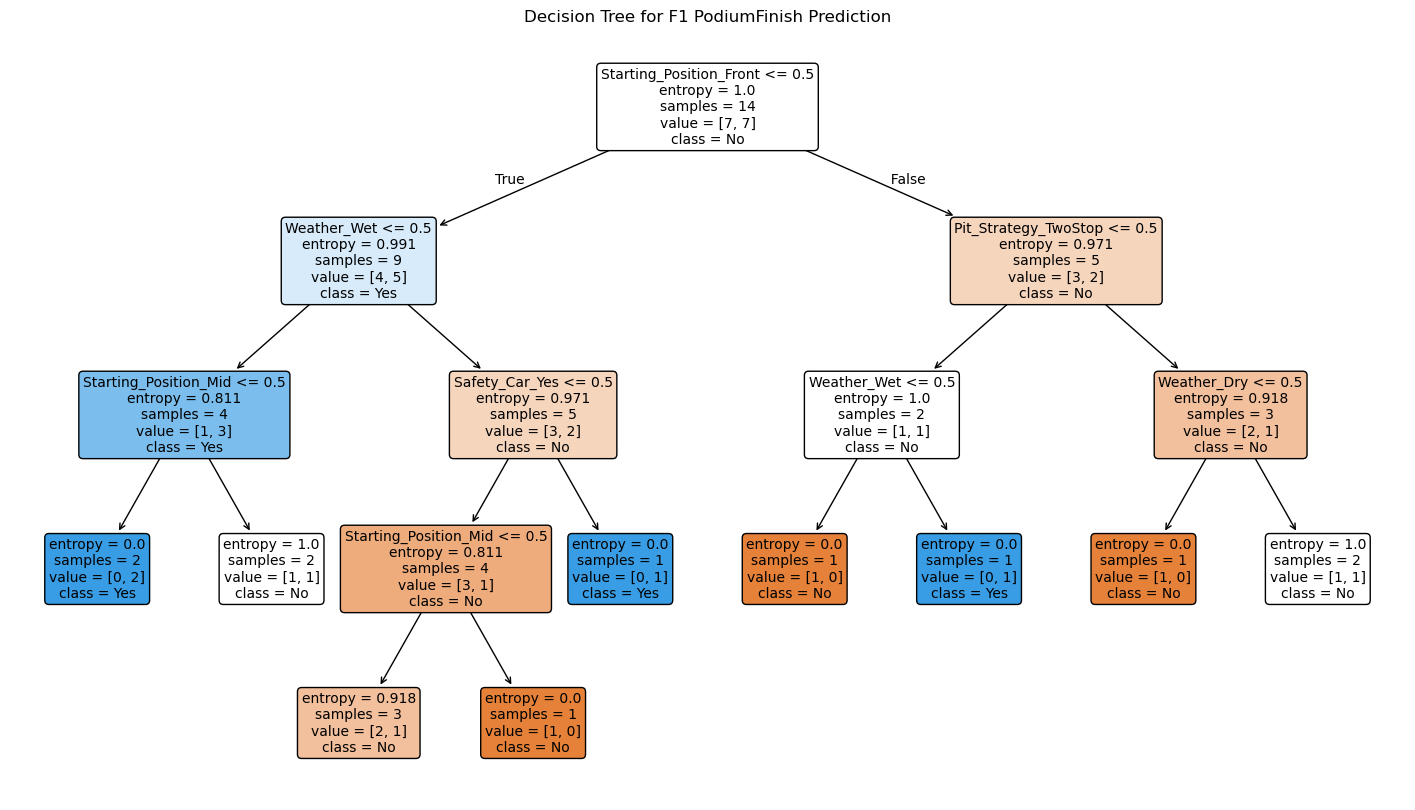

In [85]:
plt.figure(figsize=(18, 10))
plot_tree(
    dt_model,  
    feature_names=X.columns,
    class_names=['No', 'Yes'],   # PodiumFinish: No/Yes
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree for F1 PodiumFinish Prediction")
plt.show()

<div style="background-color: #e8f5e9; padding: 15px; border-radius: 8px; border-left: 5px solid #2e7d32;">
<strong>🌳Decision Tree Analysis — F1 PodiumFinish Prediction</strong>
This decision tree uses entropy and information gain to iteratively reduce uncertainty in predicting podium finishes. Starting position is selected as the root node due to its maximum entropy reduction. Weather and safety car presence further refine predictions for non-front starters, while pit strategy influences outcomes for front-grid drivers. As the tree grows deeper, entropy decreases within small subsets, demonstrating how information gain drives split selection but can also lead to overfitting when data is noisy.
</div>